# Analyzing neighborhoods in Toronto

This notebook obtains Toronto's postal codes from Wikipedia page https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, and finds the corresponding latitudes and longitudes

The final dataframe will consist of six columns including index: PostalCode, Borough, Neighborhood, Latitude and Longitude. This is obtained in 5 steps:
1. Read the Wiki page and parse the HTML using BeautifulSoup
2. Parse through the postcode table and create a dataframe with contents
3. Cleanse the dataframe and retain useful rows
4. Read a csv file containing geographical coordinates
5. Retrieve latitude and longitude from the csv dataframe based on Postcode

The dimensions of the final dataframe are dispayed at the end of the notebook

## 1. Read the Wiki page and parse the HTML using BeautifulSoup

In [1]:
from bs4 import BeautifulSoup
import pandas as pd
import requests

response = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup = BeautifulSoup(response.text, "html.parser")
    
# Find the postcode table section, which is the first table on the Wiki page
table = soup.table

## 2. Parse through the postcode table and create a dataframe with contents

In [2]:
# Read column titles and find number of rows
column_names = []
n_rows = 0

for row in table.find_all('tr'):
    # Find heading row <th> tags
    th_tags = row.find_all('th') 
    if len(th_tags) > 0 and len(column_names) == 0:
        for th in th_tags:
            column_names.append(th.get_text())
    # Count rows with data
    td_tags = row.find_all('td')
    if len(td_tags) > 0:
        n_rows+=1
column_names = [n.replace('\n','') for n in column_names]
        
# Create a dataframe and read data into it
df_wiki = pd.DataFrame(columns = column_names,index = range(0,n_rows))
row_marker = 0
for row in table.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        df_wiki.iat[row_marker,column_marker] = column.get_text()
        column_marker += 1
    if len(columns) > 0:
        row_marker += 1                  

# Remove newline \n characters
df_wiki = df_wiki.replace('\n','', regex=True)
df_wiki.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


## 3. Cleanse the dataframe and retain useful rows

In [3]:
# Remove rows with a borough that is Not assigned
df_wiki = df_wiki[df_wiki.Borough!='Not assigned']

# Make Neighbourhood values same as Borough when Not assigned
df_wiki['Neighbourhood'].replace('Not assigned',df_wiki['Borough'],inplace=True)

# Combining rows with the same postcode, with the neighborhoods separated with a comma
df_wiki['Neighbourhood'] = df_wiki.groupby(['Postcode','Borough'])['Neighbourhood'].transform(lambda x: ', '.join(x))
df_wiki = df_wiki.drop_duplicates()

df_wiki = df_wiki.reset_index()
df_wiki.head()

,index,Postcode,Borough,Neighbourhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,6,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,8,M7A,Queen's Park,Queen's Park


## Dimensions of the final dataframe

In [4]:
print("(Rows, Columns) - ",df_wiki.shape)

(Rows, Columns) -  (103, 4)


## 4. Find latitude and longitude for each postal code

Note: Attempt was made to use the geocoder library, however this was too slow. Therefore, the csv file with geographical coordinates was used to obtain latitude and longitude

In [5]:
# Reading csv file containing geographical coordinates into a dataframe

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_e8764c861c054a20afb6b04c6ac44ea0 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='jW2kFAJXBCCzrfe6UgP3T4Lt-KyG0vY-sJqXsSHMGE8Y',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_e8764c861c054a20afb6b04c6ac44ea0.get_object(Bucket='courseracapstone-donotdelete-pr-keavguhvhxmj3o',Key='Geospatial_Coordinates.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.rename(columns={'Postal Code': 'Postcode'}, inplace=True)
df_data_1.head()



,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Retrieve latitude and longitude from the csv dataframe based on Postcode

In [6]:
# Merging the two datasets on Postcode

df = pd.merge(df_wiki,df_data_1,on='Postcode')
df.head()

,index,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,2,M3A,North York,Parkwoods,43.753259,-79.329656
1,3,M4A,North York,Victoria Village,43.725882,-79.315572
2,4,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,6,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,8,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


## 5. Get Foursquare data for neighbourhoods

### Define Foursquare credentials and version

In [7]:
# Define Foursquare credentials and version

CLIENT_ID = 'IFGZGX4XZGUBSO53CJTLZUUVMW5NKPZBEVBAOYC33HNNOOPI' # your Foursquare ID
CLIENT_SECRET = 'I2HICT0K4TVXU1QTVBNMYZTCPEFPVPXF0RCGBSRBA0OQF2KP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### Get top venues for each neighbourhood

In [8]:
# Function to get top venues for each neighbourhood

def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
        print(name, borough)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Borough',                     
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Toronto venues in a new dataframe

In [9]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                 boroughs=df['Borough'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude']
                                )

print(toronto_venues.shape)

Parkwoods North York
Victoria Village North York
Harbourfront, Regent Park Downtown Toronto
Lawrence Heights, Lawrence Manor North York
Queen's Park Queen's Park
Islington Avenue Etobicoke
Rouge, Malvern Scarborough
Don Mills North North York
Woodbine Gardens, Parkview Hill East York
Ryerson, Garden District Downtown Toronto
Glencairn North York
Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park Etobicoke
Highland Creek, Rouge Hill, Port Union Scarborough
Flemingdon Park, Don Mills South North York
Woodbine Heights East York
St. James Town Downtown Toronto
Humewood-Cedarvale York
Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe Etobicoke
Guildwood, Morningside, West Hill Scarborough
The Beaches East Toronto
Berczy Park Downtown Toronto
Caledonia-Fairbanks York
Woburn Scarborough
Leaside East York
Central Bay Street Downtown Toronto
Christie Downtown Toronto
Cedarbrae Scarborough
Hillcrest Village North York
Bathurst Manor, Downsview North, Wilson Height

In [10]:
# Number of venues returned for each neighbourhood
toronto_venues.groupby('Neighbourhood').count()

,Borough,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100,100
Agincourt,4,4,4,4,4,4,4
"Agincourt North, L'Amoreaux East, Milliken, Steeles East",3,3,3,3,3,3,3
"Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown",10,10,10,10,10,10,10
"Alderwood, Long Branch",11,11,11,11,11,11,11
"Bathurst Manor, Downsview North, Wilson Heights",18,18,18,18,18,18,18
Bayview Village,4,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24,24
Berczy Park,57,57,57,57,57,57,57


## 6. Analyze neighbourhoods based on categories from all the returned venues

In [11]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 282 uniques categories.


In [12]:
# Analyze each neighborhood
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
print(toronto_grouped.shape)
toronto_grouped.head()

(99, 283)


,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.01,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0
4,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0


### Top 10 most common venuws in the neighbourhoods

In [14]:
import numpy as np
# Put into pandas dataframe

# Funtion to sort venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


# Create dataframe with top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Thai Restaurant,American Restaurant,Steakhouse,Hotel,Bakery,Restaurant,Gym,Clothing Store
1,Agincourt,Clothing Store,Lounge,Breakfast Spot,Skating Rink,Empanada Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Pizza Place,Grocery Store,Coffee Shop,Sandwich Place,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Pharmacy,Greek Restaurant,Event Space
4,"Alderwood, Long Branch",Pizza Place,Pharmacy,Coffee Shop,Skating Rink,Sandwich Place,Athletics & Sports,Pub,Pool,Dance Studio,Gym


## 7. Clustering neighbourhoods using k-means algorithm

### KMeans is run for clusters 2, 3, 4, 5, 6, and optimal number determined through Elbow method

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt

# set number of clusters
# kclusters = 4
range_n_clusters = range(2,5)
Sum_of_squared_distances = []

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering iteratively to determine optimum cluster number
for kclusters in range_n_clusters:
    kmeans = KMeans(n_clusters=kclusters, init='k-means++', random_state=0).fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(kmeans.inertia_)


### Plot of Sum of Squared Distances for all cluster numbers (Elbow method)

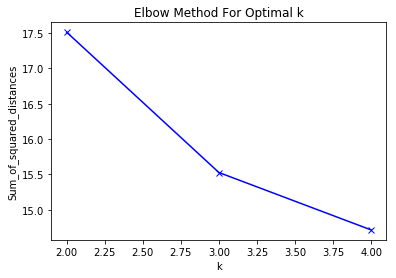

In [20]:
# Plot of sum of squared distances for values of ok
# If the plot looks like an arm, then the elbow on the arm is optimal k

plt.plot(range_n_clusters, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

### Optimum number of cluster = 3
### Running kmeans for 3 clusters

In [21]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

### Assign cluster label to each neighbourhood

In [23]:
# add clustering labels
# neighborhoods_venues_sorted.drop('Cluster Labels', axis=1, inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head()

,index,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,M3A,North York,Parkwoods,43.753259,-79.329656,0.0,Fast Food Restaurant,Park,Food & Drink Shop,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,3,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Intersection,Convenience Store,Cosmetics Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
2,4,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,1.0,Coffee Shop,Bakery,Pub,Café,Park,Mexican Restaurant,Breakfast Spot,Theater,Restaurant,Chocolate Shop
3,6,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,1.0,Clothing Store,Furniture / Home Store,Accessories Store,Gift Shop,Boutique,Event Space,Vietnamese Restaurant,Coffee Shop,Miscellaneous Shop,Doner Restaurant
4,8,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,1.0,Coffee Shop,Gym,Sushi Restaurant,Japanese Restaurant,Diner,Yoga Studio,Smoothie Shop,Seafood Restaurant,Bubble Tea Shop,Sandwich Place


### Visualize neighbourhood clusters on map

In [24]:
# Get geographical coordinates of Toronto

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [26]:
#Install folium
! pip install folium

    100% |████████████████████████████████| 92kB 7.3MB/s eta 0:00:01
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: jinja2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: MarkupSafe>=0.23 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from jinja2->folium)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->folium)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/

In [27]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
toronto_merged = toronto_merged.dropna(subset=['Cluster Labels'])

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Cluster #1

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[3] + list(range(7, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,Fast Food Restaurant,Park,Food & Drink Shop,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
21,Caledonia-Fairbanks,Park,Pharmacy,Fast Food Restaurant,Market,Women's Store,Field,Farmers Market,Falafel Restaurant,Event Space,Discount Store
35,East Toronto,Park,Convenience Store,Coffee Shop,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
40,"CFB Toronto, Downsview East",Bus Stop,Airport,Park,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant
46,Downsview West,Park,Bank,Grocery Store,Shopping Mall,Yoga Studio,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
61,Lawrence Park,Dim Sum Restaurant,Park,Bus Line,Swim School,Yoga Studio,Eastern European Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
64,Weston,Park,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
66,York Mills West,Park,Bank,Yoga Studio,Electronics Store,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Empanada Restaurant
77,"Kingsview Village, Martin Grove Gardens, Richv...",Pizza Place,Park,Bus Line,Mobile Phone Shop,Dumpling Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
85,"Agincourt North, L'Amoreaux East, Milliken, St...",Park,Playground,Yoga Studio,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant


### Cluster #2

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[3] + list(range(7, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Victoria Village,Pizza Place,Hockey Arena,Coffee Shop,Portuguese Restaurant,Intersection,Convenience Store,Cosmetics Shop,Fast Food Restaurant,Farmers Market,Falafel Restaurant
2,"Harbourfront, Regent Park",Coffee Shop,Bakery,Pub,Café,Park,Mexican Restaurant,Breakfast Spot,Theater,Restaurant,Chocolate Shop
3,"Lawrence Heights, Lawrence Manor",Clothing Store,Furniture / Home Store,Accessories Store,Gift Shop,Boutique,Event Space,Vietnamese Restaurant,Coffee Shop,Miscellaneous Shop,Doner Restaurant
4,Queen's Park,Coffee Shop,Gym,Sushi Restaurant,Japanese Restaurant,Diner,Yoga Studio,Smoothie Shop,Seafood Restaurant,Bubble Tea Shop,Sandwich Place
6,"Rouge, Malvern",Fast Food Restaurant,Yoga Studio,Empanada Restaurant,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
7,Don Mills North,Japanese Restaurant,Café,Caribbean Restaurant,Gym / Fitness Center,Basketball Court,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore
8,"Woodbine Gardens, Parkview Hill",Pizza Place,Fast Food Restaurant,Gastropub,Pharmacy,Rock Climbing Spot,Café,Bank,Intersection,Athletics & Sports,Pet Store
9,"Ryerson, Garden District",Clothing Store,Coffee Shop,Café,Cosmetics Shop,Middle Eastern Restaurant,Ramen Restaurant,Theater,Diner,Tea Room,Japanese Restaurant
10,Glencairn,Pub,Italian Restaurant,Bakery,Japanese Restaurant,Park,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Empanada Restaurant
11,"Cloverdale, Islington, Martin Grove, Princess ...",Bank,Yoga Studio,Fish Market,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant


### Cluster #3

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[3] + list(range(7, toronto_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,"Emery, Humberlea",Baseball Field,Fish Market,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Yoga Studio
101,"Humber Bay, King's Mill Park, Kingsway Park So...",Baseball Field,Fish Market,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Yoga Studio
